In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from utils.utils import load_data, remove_zero_features, standardize
from utils.utils import generate_oversampled_set, generate_undersampled_set, generate_label_stats
from utils.utils import compute_scores_binary
from utils.plot_utils import plot_pr_curves, plot_roc_curves

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

In [11]:
plot_path = 'plots/'

In [12]:
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 8


---

In [13]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [14]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])

In [15]:
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Number of samples: 2815
Number of features: 922


In [16]:
# Remove ID column
Y = diagnoses.iloc[:,1:]
print(f"Number of labels: {Y.shape[1]}")

Number of labels: 13


In [17]:
boot_iter = 100

---

# 1. Use dataset with original label distribution (no resampling)

In [18]:
label_stats, mean_ir = generate_label_stats(Y, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 7.995236107963529


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,152,0.053996,11.519737
DepressiveDisorders,300,0.106572,5.836667
Attention_Deficit_HyperactivityDisorder,1751,0.622025,1.000000
MotorDisorder,229,0.081350,7.646288
AutismSpectrumDisorder,398,0.141385,4.399497
CommunicationDisorder,493,0.175133,3.551724
OtherDisorders,135,0.047957,12.970370
SpecificLearningDisorder,761,0.270337,2.300920
Obsessive_Compulsive_And_RelatedDisorders,137,0.048668,12.781022
Disruptive,436,0.154885,4.016055


In [19]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_1_test, Y_1_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 2111
Number of samples in test set: 704


## 1.1. Logistic regression

In [20]:
lr_1_estimators = {}

In [21]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [22]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'C': 0.0001}
DepressiveDisorders: {'C': 0.0001}
Attention_Deficit_HyperactivityDisorder: {'C': 0.0001}
MotorDisorder: {'C': 0.0001}
AutismSpectrumDisorder: {'C': 0.0001}
CommunicationDisorder: {'C': 0.0001}
OtherDisorders: {'C': 0.0001}
SpecificLearningDisorder: {'C': 0.001}
Obsessive_Compulsive_And_RelatedDisorders: {'C': 0.001}
Disruptive: {'C': 0.0001}
IntellectualDisability: {'C': 0.001}
EliminationDisorder: {'C': 0.0001}
AnxietyDisorders: {'C': 0.0001}


In [23]:
compute_scores_binary(lr_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.20 (0.01) [0.19, 0.22]
auprc_weighted:               0.34 (0.01) [0.32, 0.36]
auroc_macro:                  0.54 (0.01) [0.52, 0.56]
auroc_weighted:               0.53 (0.01) [0.51, 0.55]
brier_macro:                  0.25 (0.00) [0.25, 0.25]
brier_weighted:               0.04 (0.00) [0.04, 0.04]
balanced_accuracy_macro:      0.53 (0.01) [0.51, 0.55]
balanced_accuracy_weighted:   0.09 (0.00) [0.08, 0.09]
f1_micro:                     0.27 (0.01) [0.25, 0.28]
hamming:                      0.49 (0.01) [0.47, 0.52]
subset_accuracy:              0.07 (0.01) [0.05, 0.09]


## 1.2. Histogram-based Gradient Boosting

In [24]:
hgb_1_estimators = {}

In [25]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [26]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_1_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200}
DepressiveDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 100}
Attention_Deficit_HyperactivityDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 200}
MotorDisorder: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 100}
AutismSpectrumDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100}
CommunicationDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100}
OtherDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 100}
SpecificLearningDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 200}
Obsessive_Compulsive_And_RelatedDisorders: {'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_iter': 200}
Disruptive: {'l2_regularization': 0.001, 'learning_rate': 0.01, 'max_iter': 100}
IntellectualDisability: {'l2_regularization': 0.1, 'learning_rate': 

In [27]:
compute_scores_binary(hgb_1_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.20 (0.01) [0.18, 0.21]
auprc_weighted:               0.34 (0.01) [0.32, 0.36]
auroc_macro:                  0.53 (0.01) [0.50, 0.55]
auroc_weighted:               0.52 (0.01) [0.50, 0.54]
brier_macro:                  0.18 (0.00) [0.18, 0.18]
brier_weighted:               0.04 (0.00) [0.04, 0.04]
balanced_accuracy_macro:      0.51 (0.01) [0.50, 0.52]
balanced_accuracy_weighted:   0.08 (0.00) [0.08, 0.09]
f1_micro:                     0.12 (0.01) [0.10, 0.15]
hamming:                      0.21 (0.01) [0.19, 0.22]
subset_accuracy:              0.10 (0.01) [0.08, 0.12]


# 2. Use undersampled dataset

In [28]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [29]:
X_under, Y_under = generate_undersampled_set(X_train, Y_train)
label_stats, mean_ir = generate_label_stats(Y_under, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 2.956543202759316


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,38,0.051701,4.473684
DepressiveDisorders,80,0.108844,2.125000
Attention_Deficit_HyperactivityDisorder,170,0.231293,1.000000
MotorDisorder,52,0.070748,3.269231
AutismSpectrumDisorder,101,0.137415,1.683168
CommunicationDisorder,75,0.102041,2.266667
OtherDisorders,35,0.047619,4.857143
SpecificLearningDisorder,128,0.174150,1.328125
Obsessive_Compulsive_And_RelatedDisorders,32,0.043537,5.312500
Disruptive,74,0.100680,2.297297


In [30]:
X_train, Y_train = X_under, Y_under
X_2_test, Y_2_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 735
Number of samples in test set: 704


## 2.1. Logistic regression

In [31]:
lr_2_estimators = {}

In [32]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [33]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_2_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'C': 0.001}
DepressiveDisorders: {'C': 0.0001}
Attention_Deficit_HyperactivityDisorder: {'C': 0.0001}
MotorDisorder: {'C': 0.0001}
AutismSpectrumDisorder: {'C': 0.001}
CommunicationDisorder: {'C': 0.001}


OtherDisorders: {'C': 0.0001}
SpecificLearningDisorder: {'C': 0.1}
Obsessive_Compulsive_And_RelatedDisorders: {'C': 0.0001}
Disruptive: {'C': 10}
IntellectualDisability: {'C': 0.0001}
EliminationDisorder: {'C': 0.001}
AnxietyDisorders: {'C': 0.0001}


In [34]:
compute_scores_binary(lr_2_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.20 (0.01) [0.18, 0.22]
auprc_weighted:               0.32 (0.01) [0.30, 0.35]
auroc_macro:                  0.52 (0.01) [0.49, 0.54]
auroc_weighted:               0.50 (0.01) [0.48, 0.53]
brier_macro:                  0.14 (0.00) [0.14, 0.15]
brier_weighted:               0.04 (0.00) [0.04, 0.04]
balanced_accuracy_macro:      0.50 (0.00) [0.50, 0.50]
balanced_accuracy_weighted:   0.08 (0.00) [0.08, 0.08]
f1_micro:                     0.00 (0.00) [0.00, 0.00]
hamming:                      0.17 (0.00) [0.16, 0.17]
subset_accuracy:              0.10 (0.01) [0.08, 0.12]


## 2.2. Histogram-based Gradient Boosting

In [35]:
hgb_2_estimators = {}

In [36]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [37]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_2_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}
DepressiveDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 100}
Attention_Deficit_HyperactivityDisorder: {'l2_regularization': 0.001, 'learning_rate': 0.05, 'max_iter': 100}
MotorDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'max_iter': 100}
AutismSpectrumDisorder: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 100}
CommunicationDisorder: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 200}
OtherDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 200}
SpecificLearningDisorder: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 100}
Obsessive_Compulsive_And_RelatedDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 100}
Disruptive: {'l2_regularization': 0.001, 'learning_rate': 0.05, 'max_iter': 200}
IntellectualDisability: {'l2_regularization': 0.01, 'learning_rate

In [38]:
compute_scores_binary(hgb_2_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.18 (0.01) [0.17, 0.19]
auprc_weighted:               0.31 (0.01) [0.29, 0.33]
auroc_macro:                  0.50 (0.01) [0.48, 0.52]
auroc_weighted:               0.49 (0.01) [0.48, 0.51]
brier_macro:                  0.16 (0.00) [0.15, 0.17]
brier_weighted:               0.05 (0.00) [0.05, 0.05]
balanced_accuracy_macro:      0.50 (0.00) [0.50, 0.51]
balanced_accuracy_weighted:   0.08 (0.00) [0.08, 0.08]
f1_micro:                     0.03 (0.01) [0.01, 0.05]
hamming:                      0.18 (0.01) [0.17, 0.19]
subset_accuracy:              0.10 (0.01) [0.08, 0.12]


# 3. Use oversampled dataset

In [39]:
# Split dataset into train and test (holdout) set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [40]:
X_over, Y_over = generate_oversampled_set(X, Y)
label_stats, mean_ir = generate_label_stats(Y_over, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 1.6092872677464145


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,2580,0.116174,1.923256
DepressiveDisorders,3170,0.142741,1.565300
Attention_Deficit_HyperactivityDisorder,4582,0.206322,1.082933
MotorDisorder,3134,0.141120,1.583280
AutismSpectrumDisorder,3689,0.166111,1.345080
CommunicationDisorder,4431,0.199523,1.119838
OtherDisorders,2320,0.104467,2.138793
SpecificLearningDisorder,4962,0.223433,1.000000
Obsessive_Compulsive_And_RelatedDisorders,2668,0.120137,1.859820
Disruptive,2801,0.126126,1.771510


In [41]:
X_train, Y_train = X_over, Y_over
X_3_test, Y_3_test = X_test, Y_test # for plotting
print(f"Number of samples in training set: {len(X_train)}")
print(f"Number of samples in test set: {len(X_test)}")

Number of samples in training set: 22208
Number of samples in test set: 704


## 3.1. Logistic regression

In [42]:
lr_3_estimators = {}

In [43]:
p_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

gs = GridSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [44]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    lr_3_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Trauma_And_Stress_RelatedDisorders: {'C': 1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


DepressiveDisorders: {'C': 1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Attention_Deficit_HyperactivityDisorder: {'C': 10}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MotorDisorder: {'C': 1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


AutismSpectrumDisorder: {'C': 1}
CommunicationDisorder: {'C': 1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


OtherDisorders: {'C': 0.1}
SpecificLearningDisorder: {'C': 1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Obsessive_Compulsive_And_RelatedDisorders: {'C': 1}
Disruptive: {'C': 0.1}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


IntellectualDisability: {'C': 0.1}
EliminationDisorder: {'C': 0.1}
AnxietyDisorders: {'C': 10}


In [45]:
compute_scores_binary(lr_3_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.22 (0.01) [0.20, 0.23]
auprc_weighted:               0.40 (0.01) [0.37, 0.42]
auroc_macro:                  0.54 (0.01) [0.52, 0.56]
auroc_weighted:               0.58 (0.01) [0.56, 0.60]
brier_macro:                  0.26 (0.01) [0.24, 0.27]
brier_weighted:               0.05 (0.00) [0.04, 0.05]
balanced_accuracy_macro:      0.53 (0.01) [0.52, 0.55]
balanced_accuracy_weighted:   0.09 (0.00) [0.09, 0.10]
f1_micro:                     0.27 (0.01) [0.25, 0.29]
hamming:                      0.34 (0.01) [0.32, 0.36]
subset_accuracy:              0.08 (0.01) [0.07, 0.10]


## 3.2. Histogram-based Gradient Boosting

In [46]:
hgb_3_estimators = {}

In [47]:
p_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [100, 200] ,
    "l2_regularization": [0.001, 0.01, 0.1],
}

gs = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=0),
    param_grid=p_grid,
    scoring='average_precision',
    n_jobs=-1,
    refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=0),
    return_train_score=True)

In [48]:
# Perform grid search for every label
for l, label in enumerate(Y.columns):
    y_train = Y_train.iloc[:, l]
    gs.fit(X_train, np.ravel(y_train))

    hgb_3_estimators[label] = gs
    print(f"{label}: {gs.best_params_}")

Trauma_And_Stress_RelatedDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.05, 'max_iter': 200}
DepressiveDisorders: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}
Attention_Deficit_HyperactivityDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}
MotorDisorder: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 200}
AutismSpectrumDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_iter': 200}
CommunicationDisorder: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 200}
OtherDisorders: {'l2_regularization': 0.001, 'learning_rate': 0.05, 'max_iter': 200}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SpecificLearningDisorder: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 200}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Obsessive_Compulsive_And_RelatedDisorders: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 200}


/Users/damianjaspar/.venv/neuro/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Disruptive: {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_iter': 200}
IntellectualDisability: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 100}
EliminationDisorder: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_iter': 200}
AnxietyDisorders: {'l2_regularization': 0.001, 'learning_rate': 0.1, 'max_iter': 200}


In [49]:
compute_scores_binary(hgb_3_estimators, X_test, Y_test, boot_iter)

Mean scores with SE and 95% confidence intervals:

auprc_macro:                  0.26 (0.01) [0.24, 0.27]
auprc_weighted:               0.46 (0.01) [0.43, 0.47]
auroc_macro:                  0.56 (0.01) [0.55, 0.59]
auroc_weighted:               0.63 (0.01) [0.61, 0.65]
brier_macro:                  0.34 (0.01) [0.32, 0.37]
brier_weighted:               0.06 (0.00) [0.05, 0.06]
balanced_accuracy_macro:      0.57 (0.01) [0.55, 0.59]
balanced_accuracy_weighted:   0.10 (0.00) [0.10, 0.10]
f1_micro:                     0.32 (0.01) [0.30, 0.34]
hamming:                      0.36 (0.01) [0.33, 0.39]
subset_accuracy:              0.10 (0.01) [0.08, 0.12]


# 4. Plot PR curve

## 4.1.

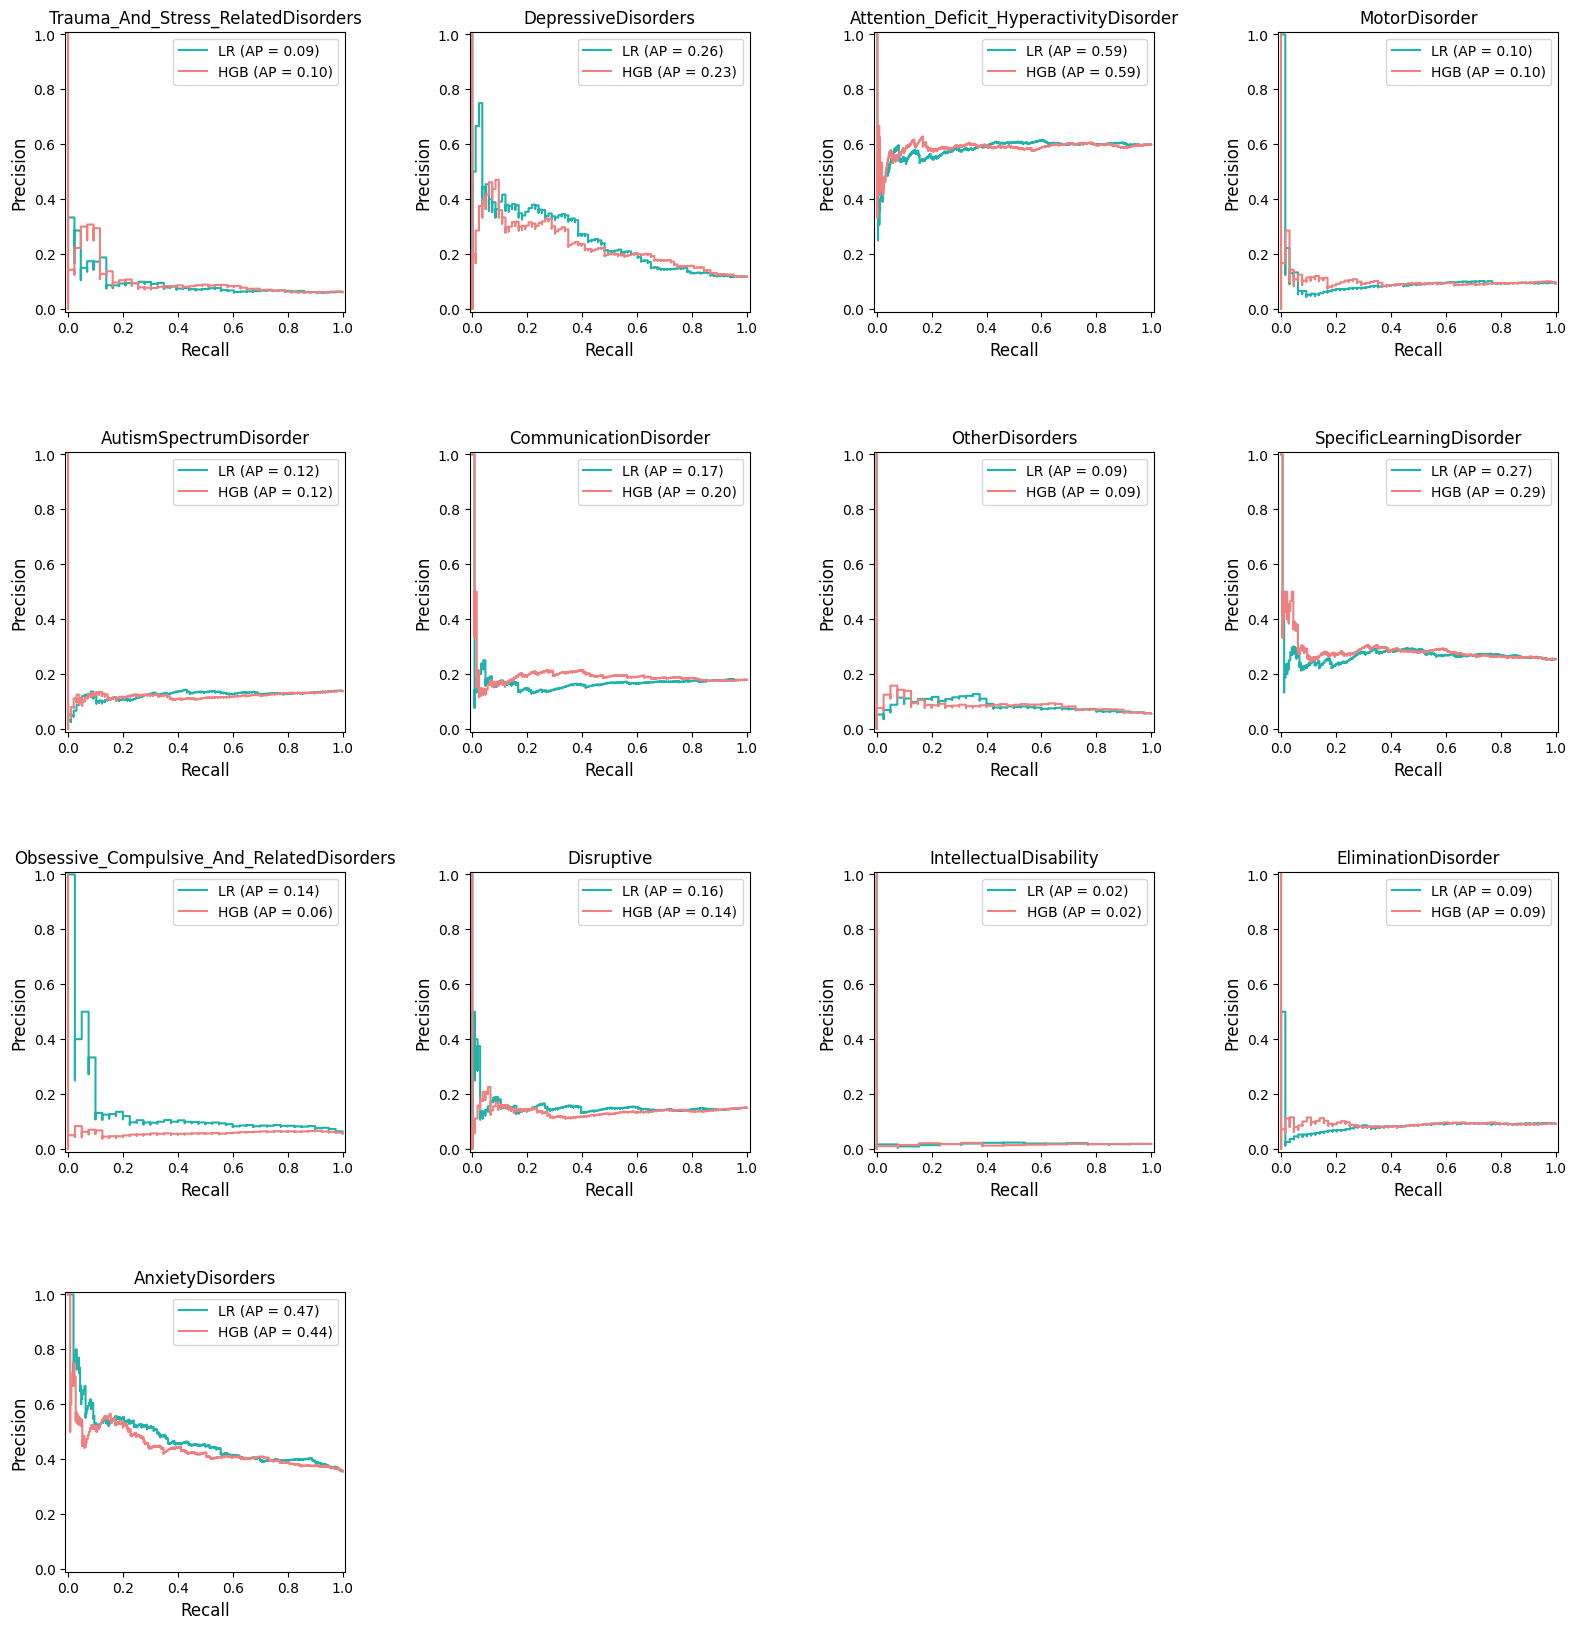

In [50]:
plot_pr_curves(X_1_test, Y_1_test, lr_1_estimators, hgb_1_estimators, 'regular')

## 4.2.

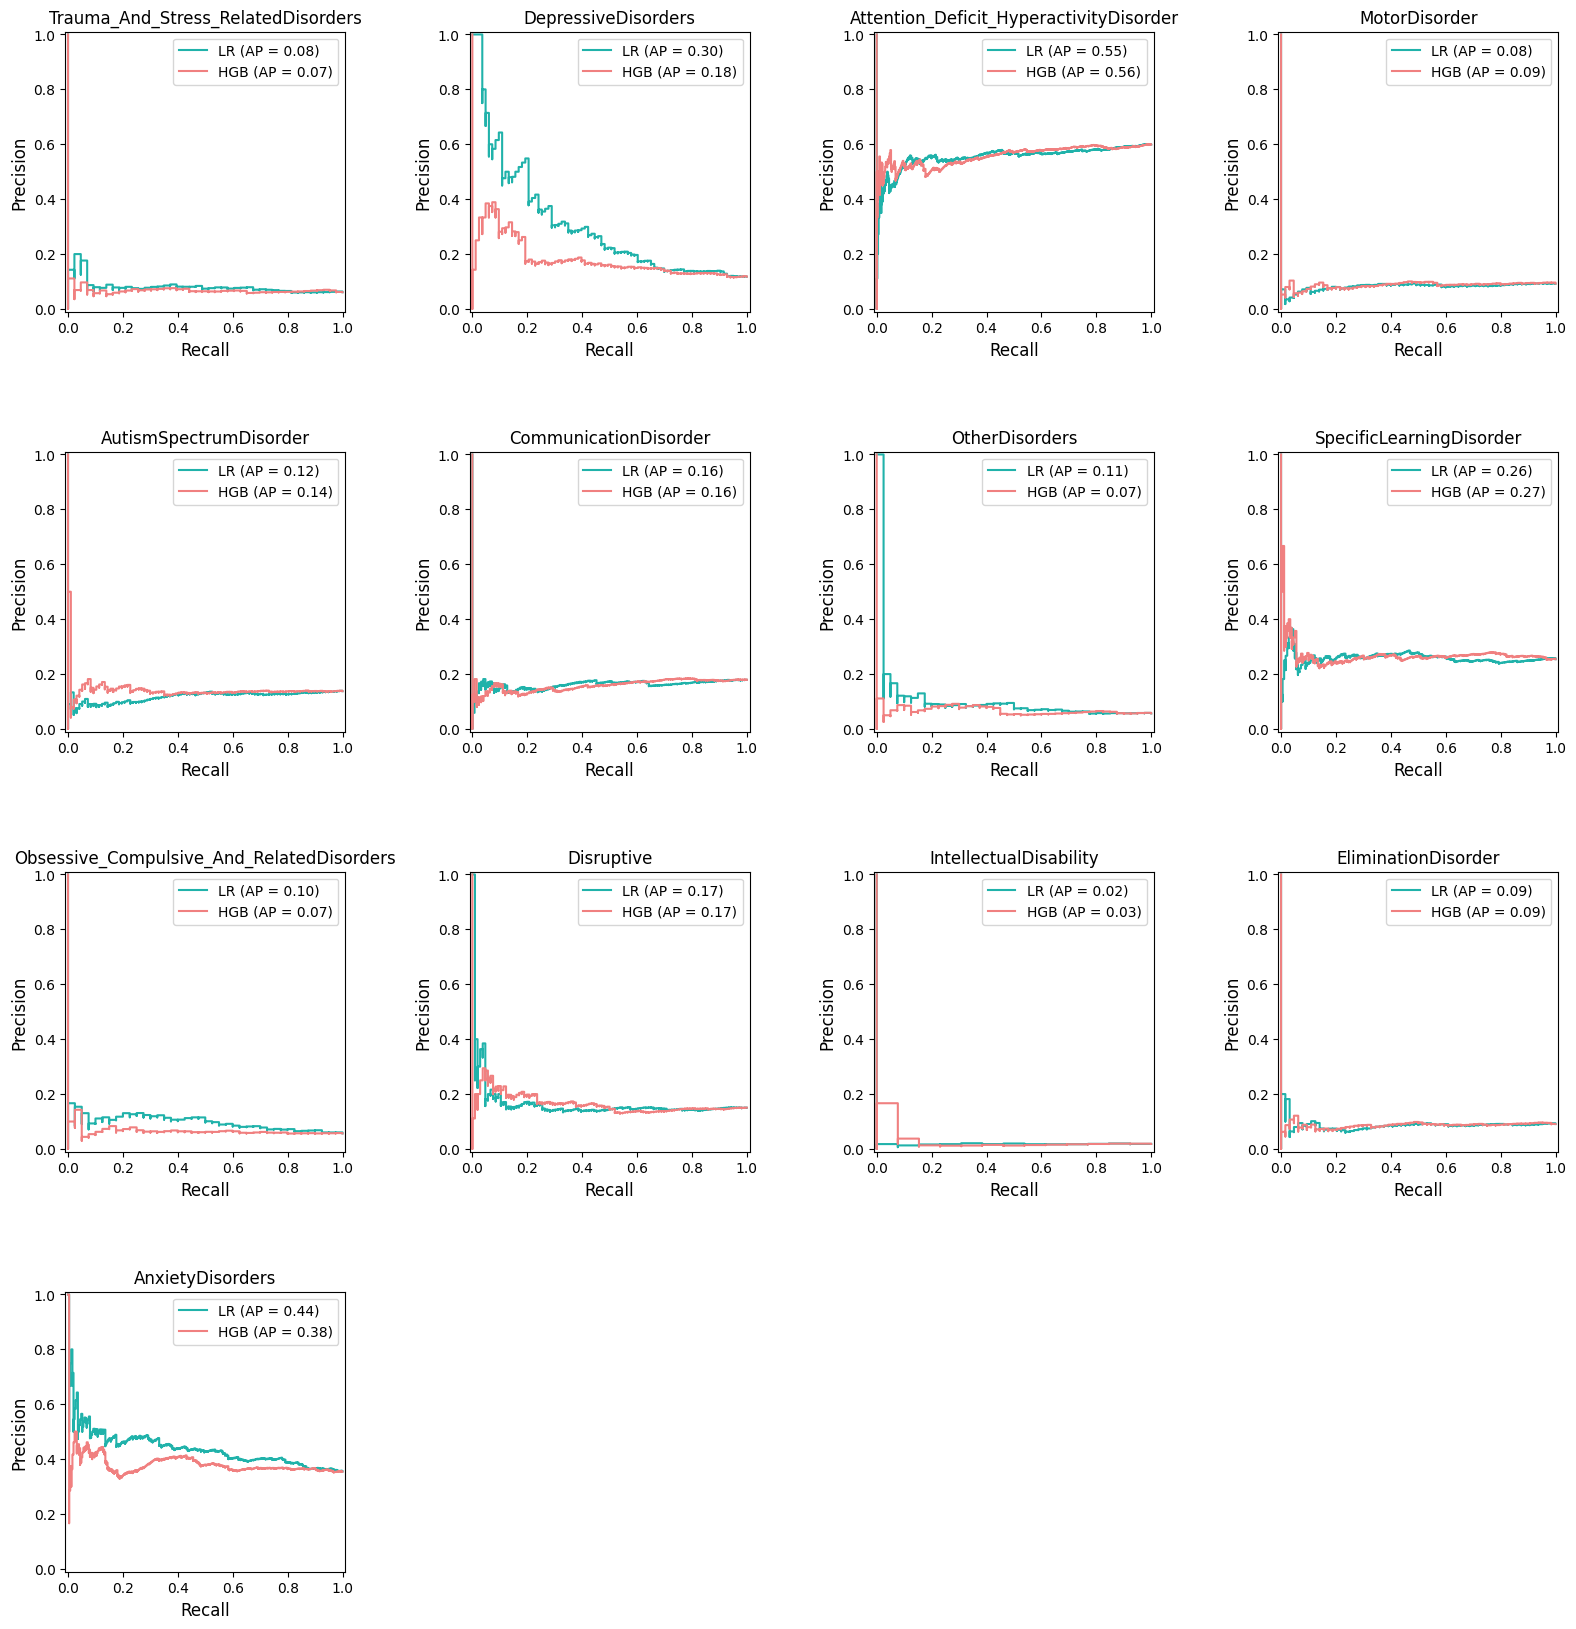

In [51]:
plot_pr_curves(X_2_test, Y_2_test, lr_2_estimators, hgb_2_estimators, 'under')

## 4.3.

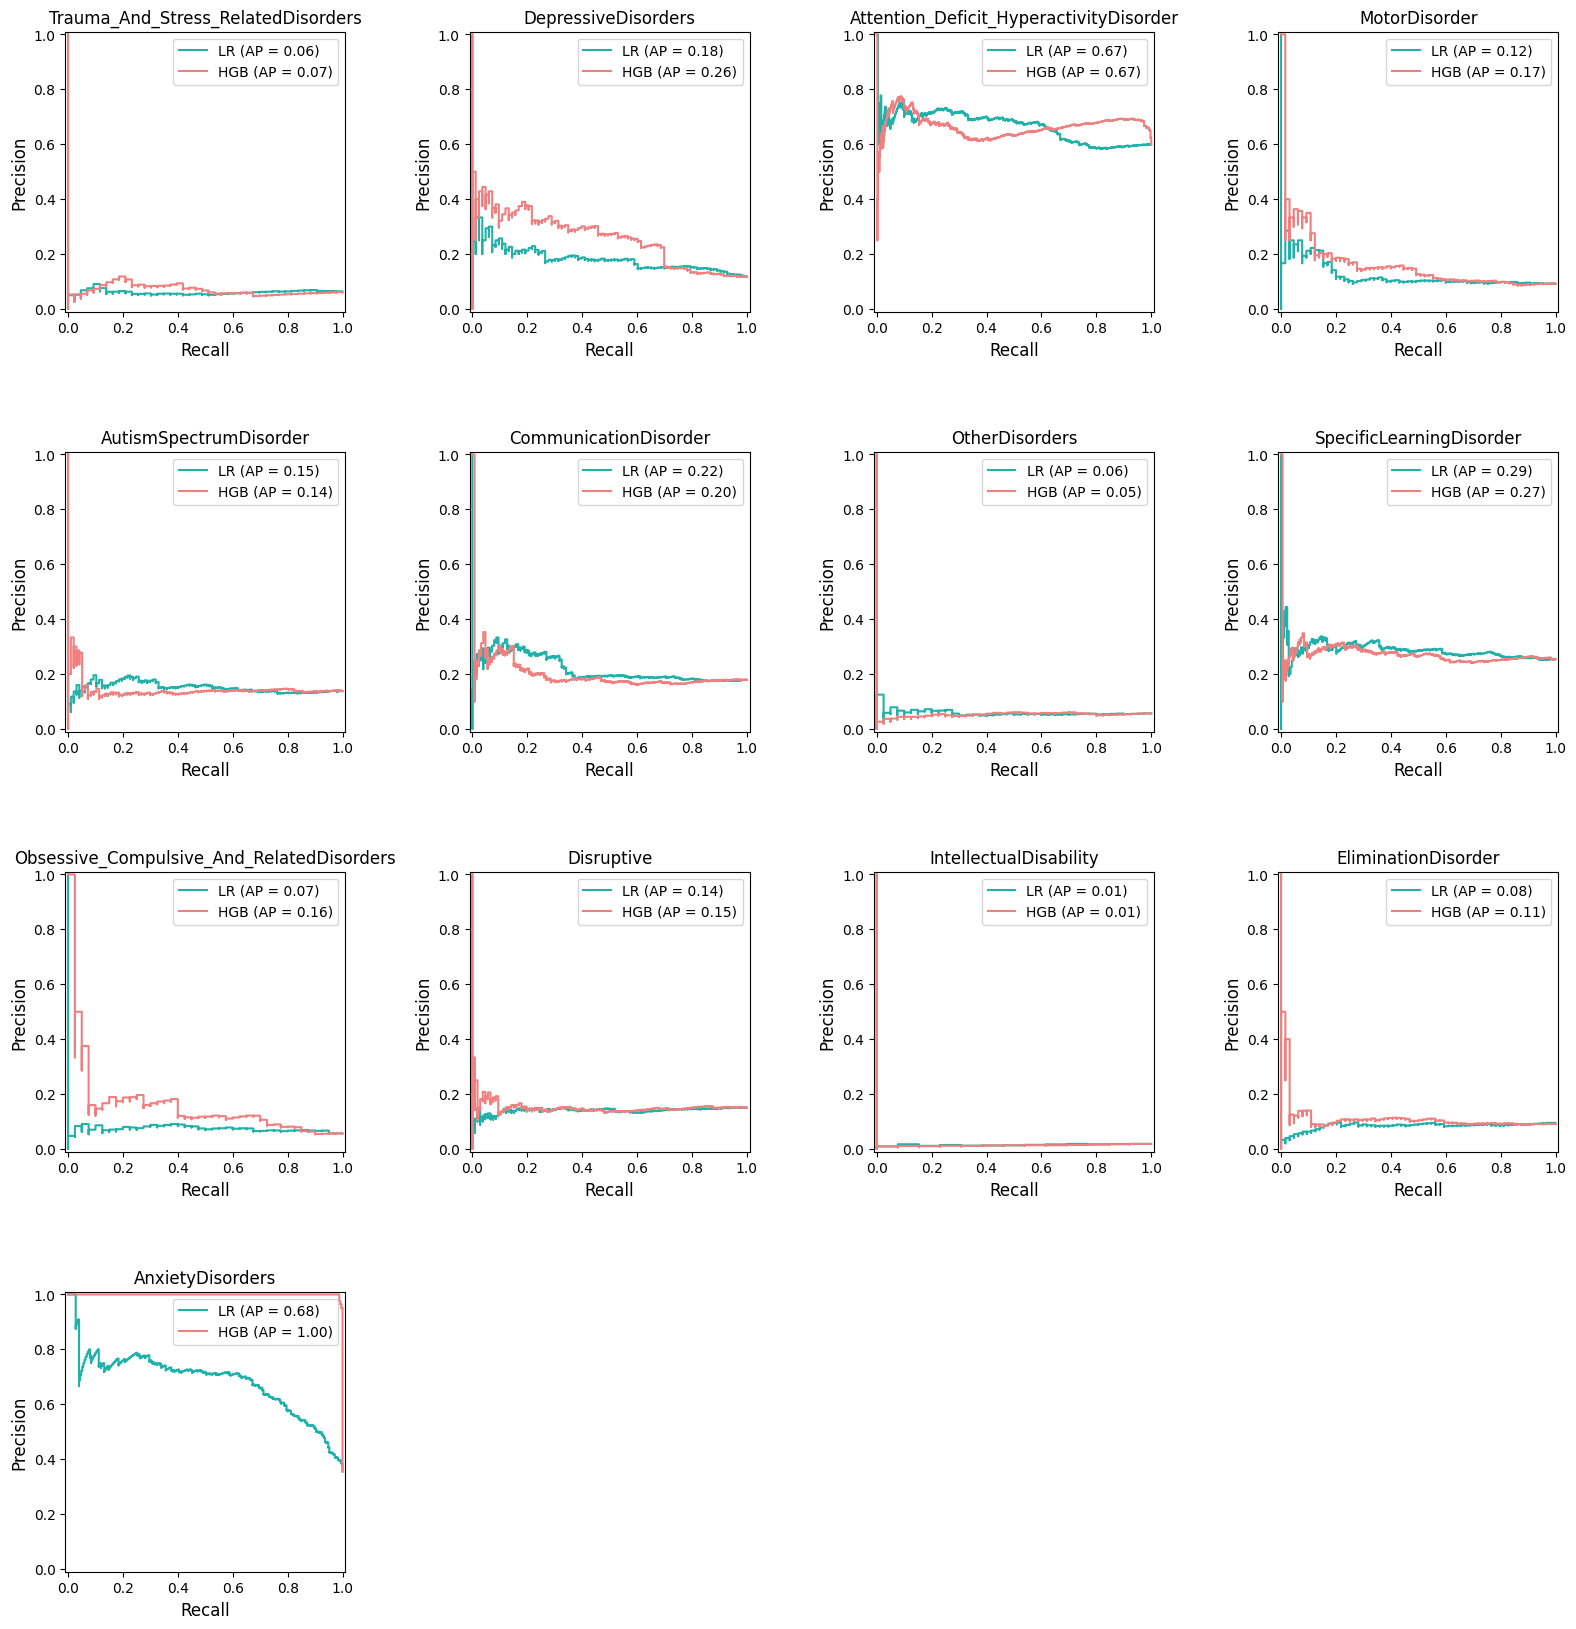

In [52]:
plot_pr_curves(X_3_test, Y_3_test, lr_3_estimators, hgb_3_estimators, 'over')

# 5. Plot ROC curve

## 5.1.

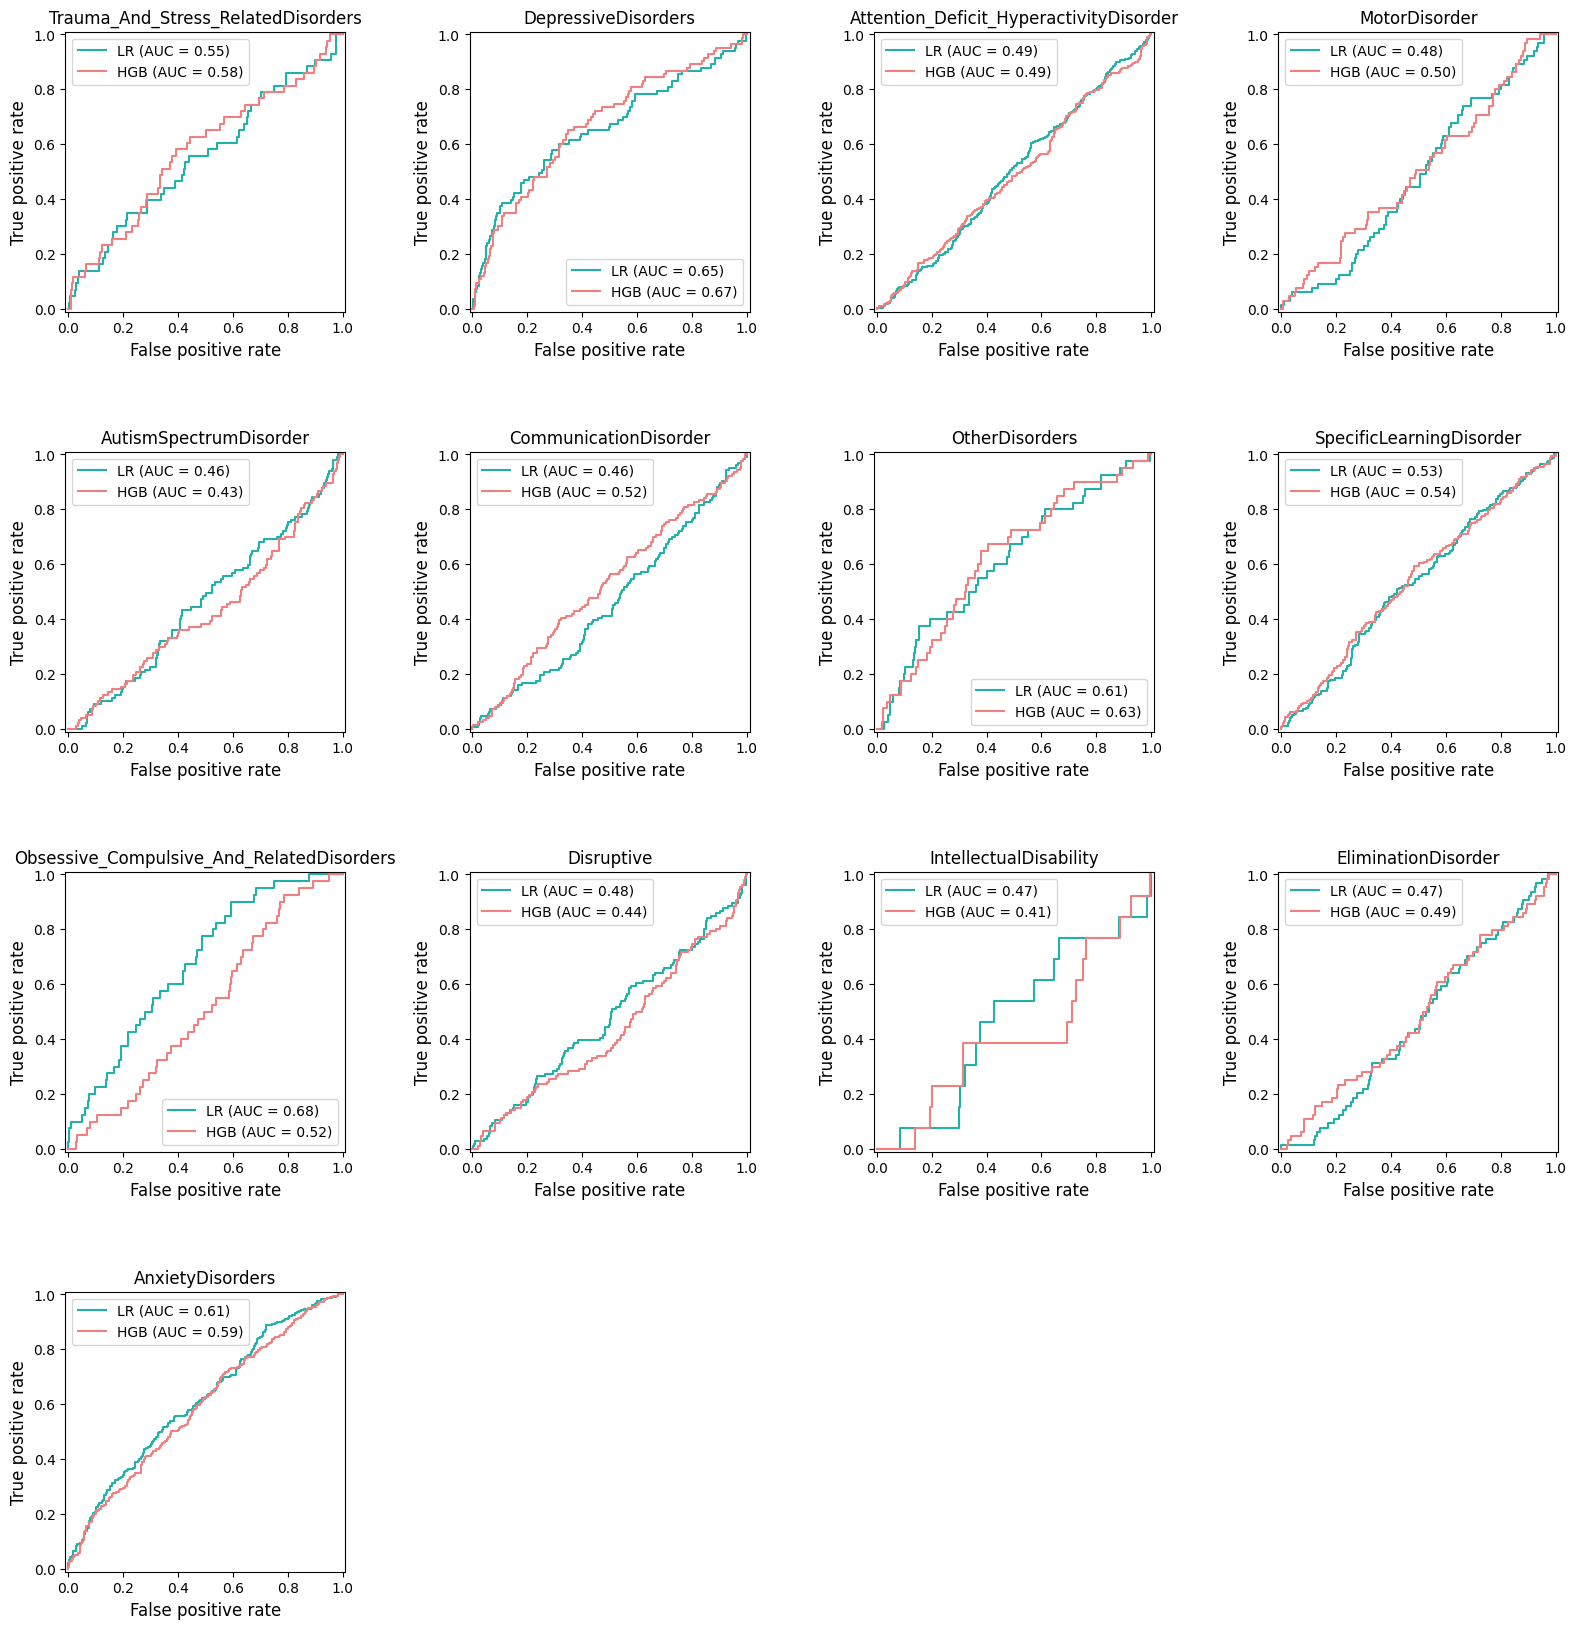

In [53]:
plot_roc_curves(X_1_test, Y_1_test, lr_1_estimators, hgb_1_estimators, 'regular')

## 5.2.

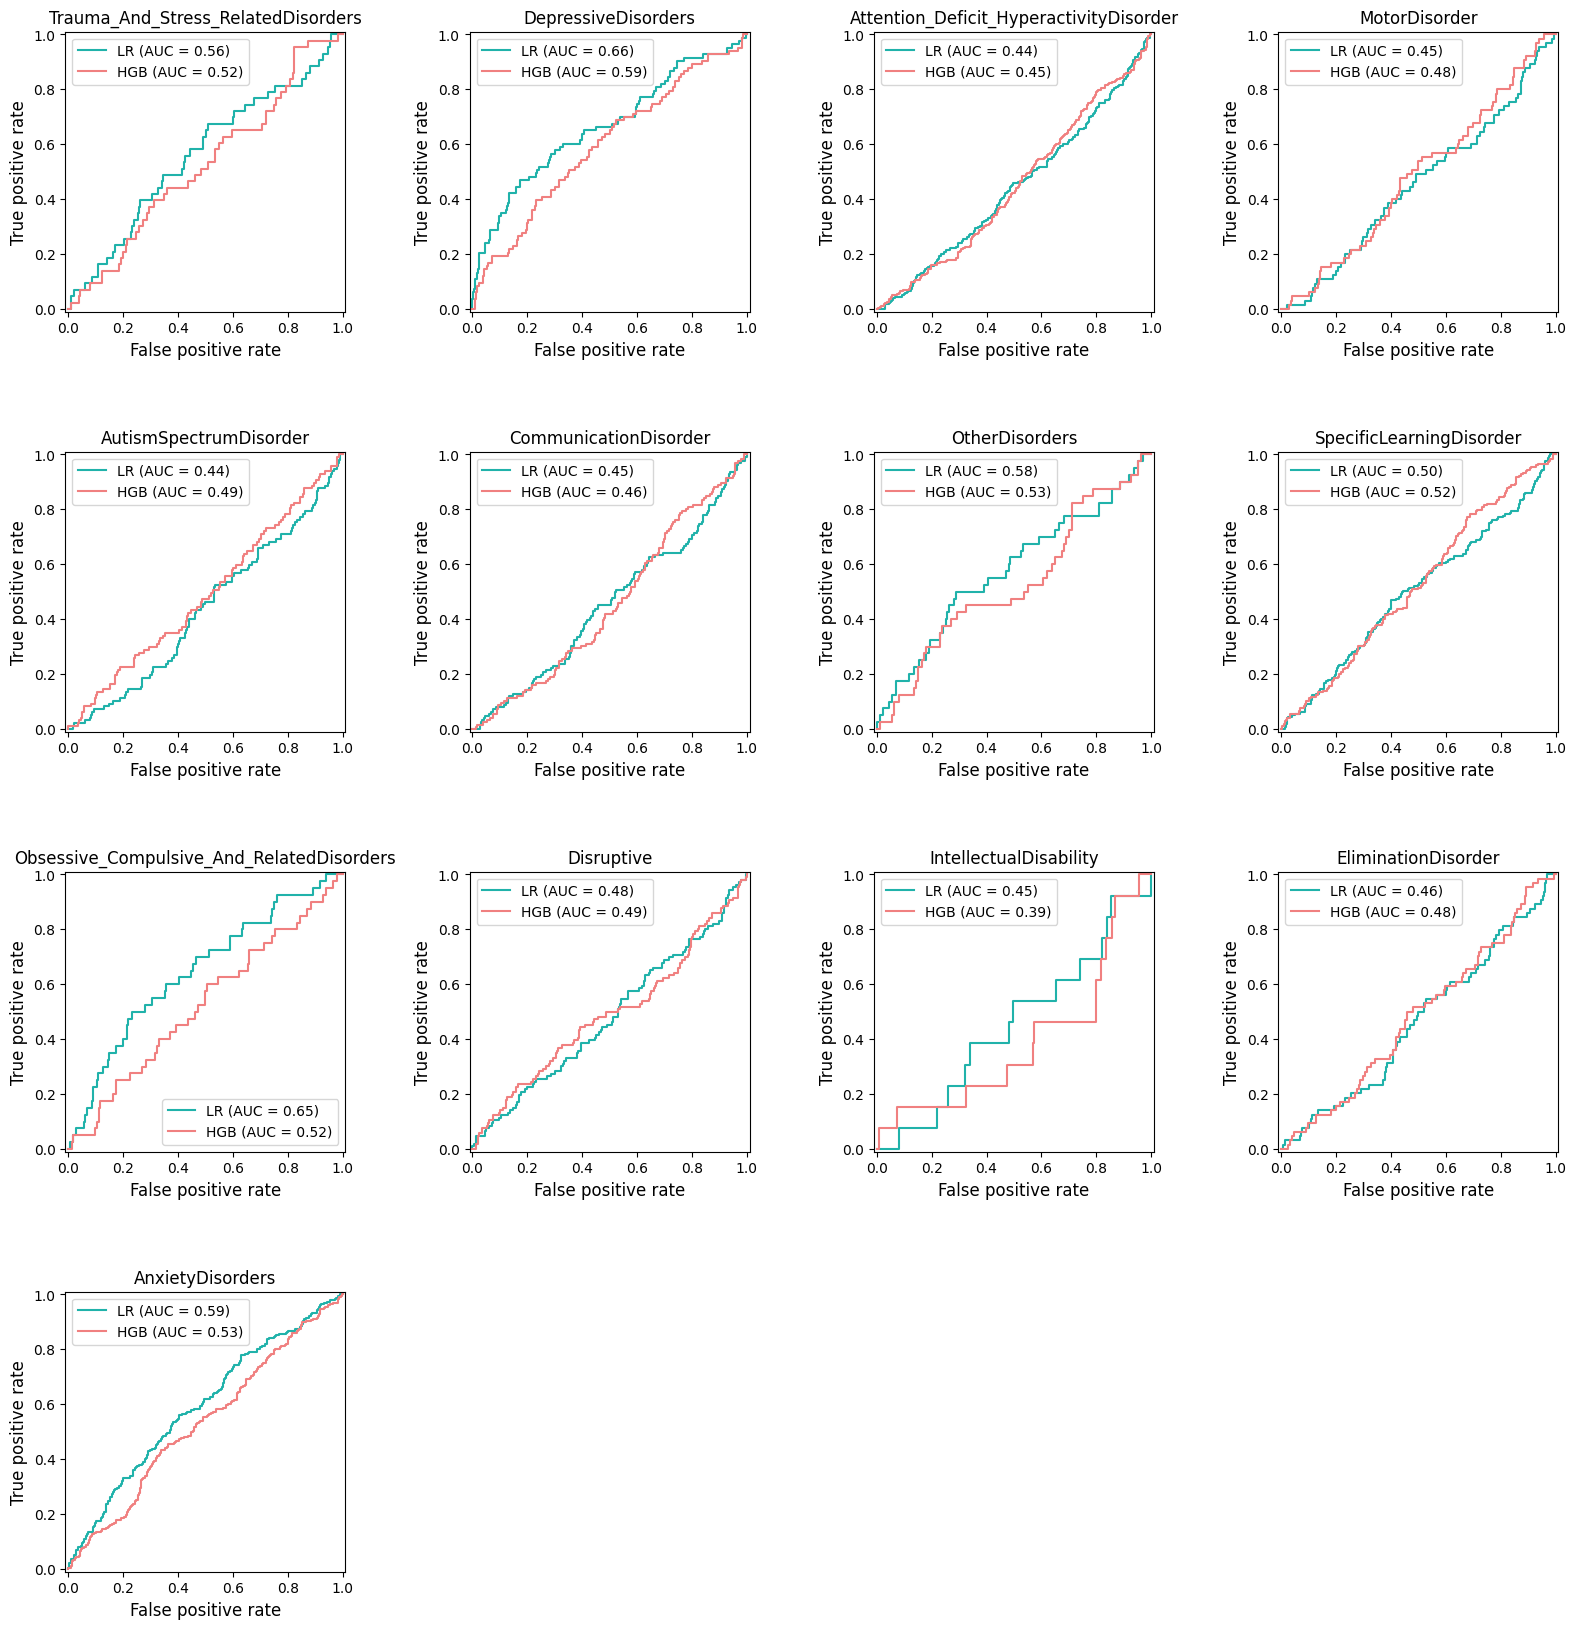

In [54]:
plot_roc_curves(X_2_test, Y_2_test, lr_2_estimators, hgb_2_estimators, 'under')

## 5.3.

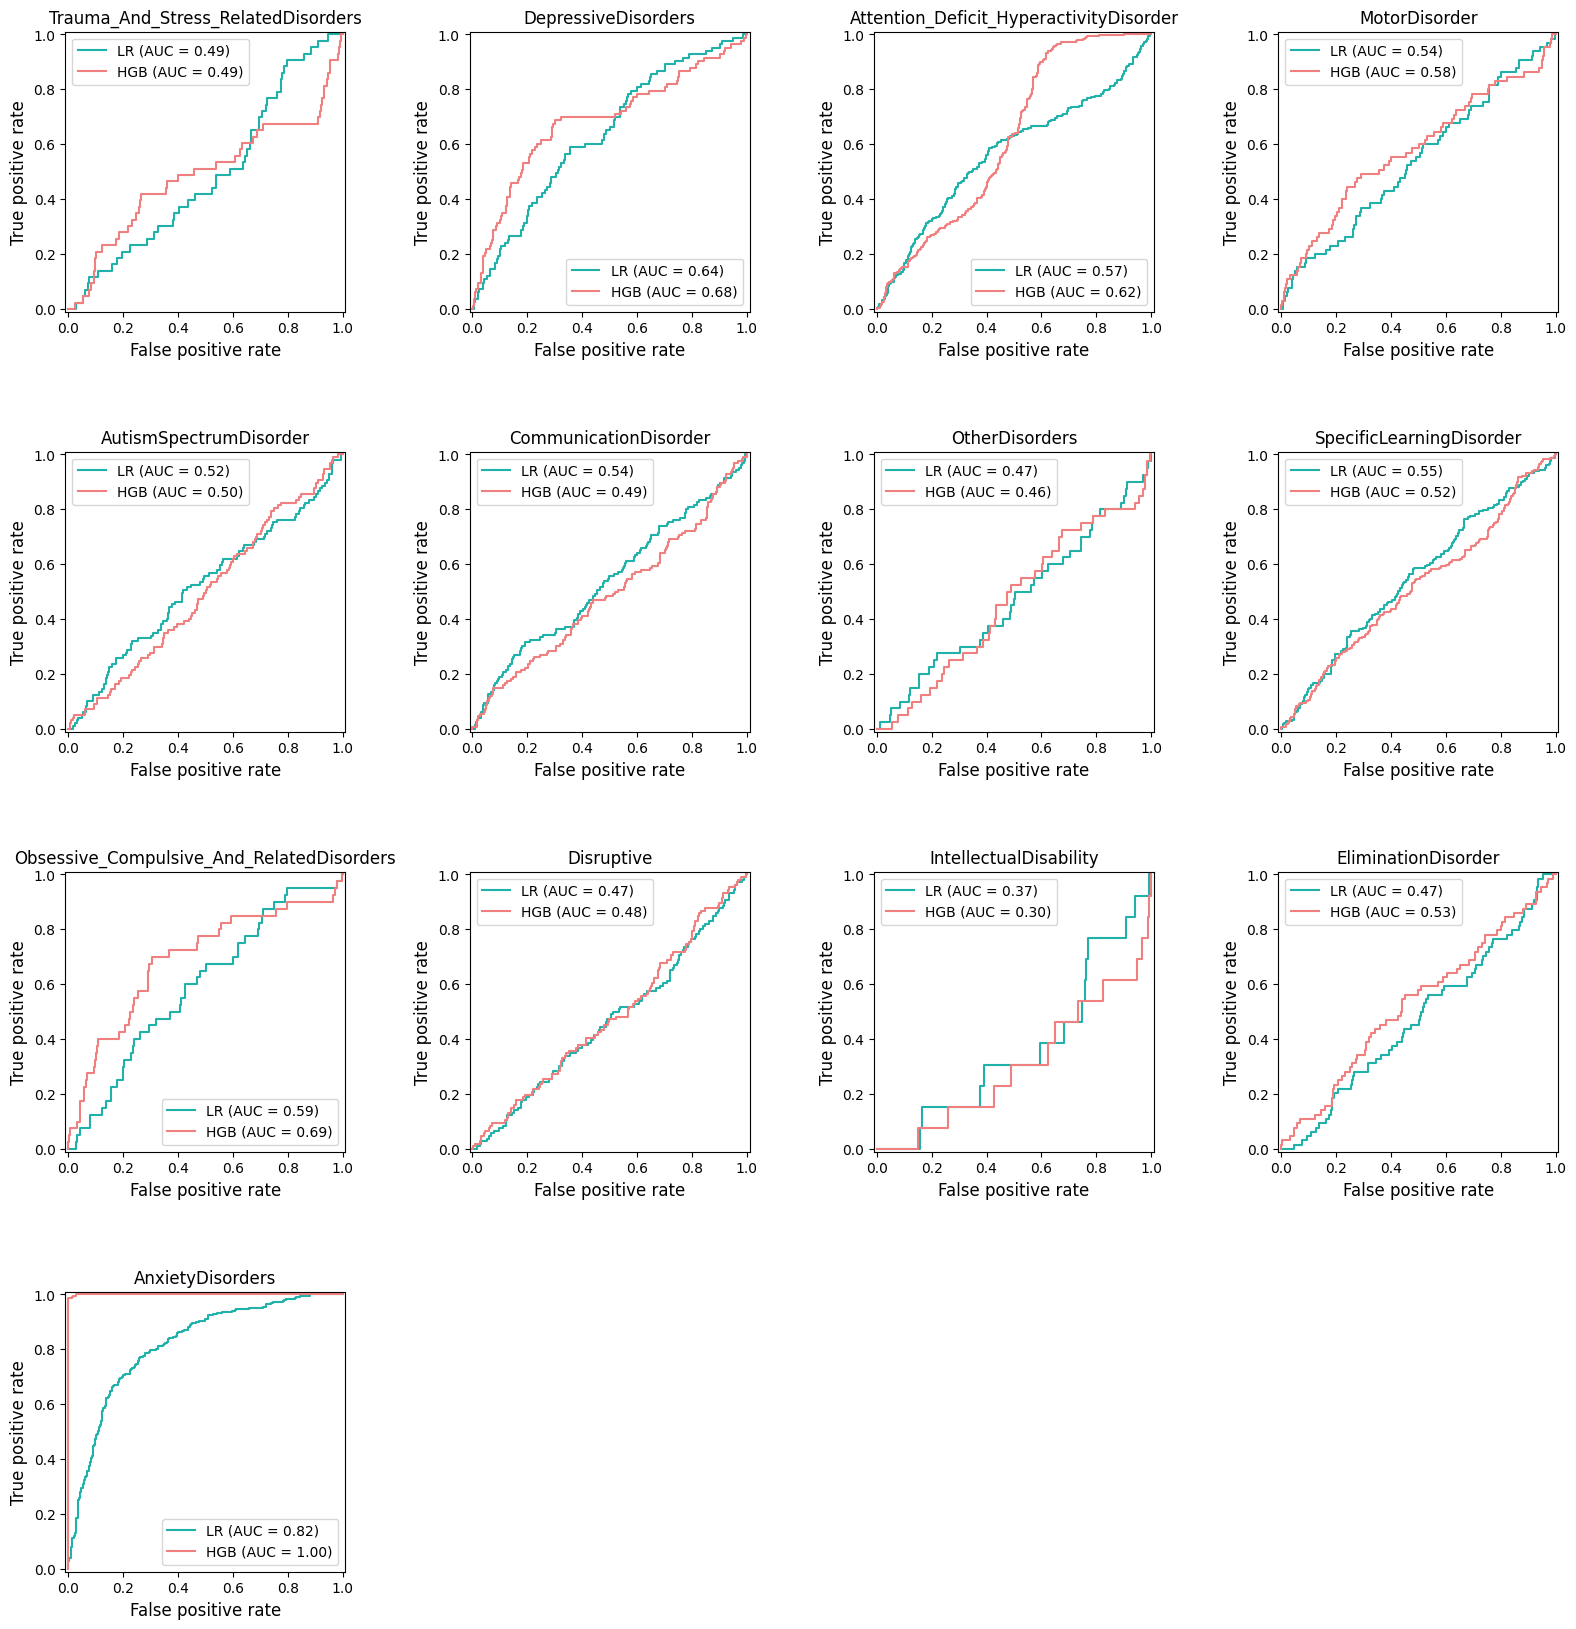

In [55]:
plot_roc_curves(X_3_test, Y_3_test, lr_3_estimators, hgb_3_estimators, 'over')